In [6]:
import pandas as pd
import random
from scipy.stats import pearsonr


ALGORITHM = "DIPK"
SAMPLE = "picked"

def get_results_and_drug_vis(algorithm, sample, LCO, normalized):

    t_vs_p_path = 'to_the_stars/true_vs_pred.csv' if LCO else 'to_the_universe_new/true_vs_pred.csv'
    results = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int})
    results = results[results['rand_setting'] =="predictions"]

    results = results[results['algorithm'] ==algorithm]

    # Load drug name mapping
    pubchem_id_to_drugname = pd.read_csv('../data/CTRPv2/drug_names.csv')


    if sample == "picked":
        viz_drugs = ["bafilomycin A1", "chlorambucil", "NSC 74859","hyperforin", "Docetaxel", "C6-ceramide", "obatoclax", "Entinostat", "etomoxir"]
        pubchem_ids = []
        for drug in viz_drugs:
            pubchem_ids.append(pubchem_id_to_drugname[pubchem_id_to_drugname['drug_name'] == drug]['pubchem_id'].values[0])
        viz_drugs = pubchem_ids
    elif sample == "top":
        viz_drugs = results['drug'].value_counts().index[:10]
    elif sample == "random":
        viz_drugs = results['drug'].unique()
        #choose  random drugs
        random.seed(42)
        viz_drugs = random.sample(list(viz_drugs), 12)
    elif sample =="lowest_pearson":

        # Compute Pearson correlation per drug
        pearsons = results.groupby('drug').apply(lambda g: pearsonr(g['y_true'], g['y_pred'])[0])

        # Drop NaNs (in case a drug has constant y_true or y_pred)
        pearsons = pearsons.dropna()

        # Select 10 drugs with lowest Pearson correlation
        viz_drugs = pearsons.nsmallest(50).index.tolist()
    else:
        raise ValueError("Invalid sample option")

    # Filter mapping to only include  viz drugs
    top_drug_names = pubchem_id_to_drugname[pubchem_id_to_drugname['pubchem_id'].isin(viz_drugs)]

    # Create mapping dict
    id_to_name = dict(zip(top_drug_names['pubchem_id'], top_drug_names['drug_name']))
    results['drug'] = results['drug'].astype(str)
    pubchem_id_to_drugname['pubchem_id'] = pubchem_id_to_drugname['pubchem_id'].astype(str)

    # Map drug IDs to names, fill with "Other" if not in 
    results["drug_name_viz"] = results['drug'].map(id_to_name).fillna("Other")
    if not normalized:
        return results
    else:

        # Load and filter
        results2 = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int}, index_col=0)
        results2 = results2[results2["rand_setting"] == "predictions"]

        # Ensure consistent types
        results2["drug"] = results2["drug"].astype(str)
        results2["cell_line"] = results2["cell_line"].astype(str)
        results2["CV_split"] = results2["CV_split"].astype(int)

        # Prepare naive predictions
        naive = results2[results2["algorithm"] == "NaiveMeanEffectsPredictor"].copy()
        naive["drug"] = naive["drug"].astype(str)
        naive["cell_line"] = naive["cell_line"].astype(str)
        naive["CV_split"] = naive["CV_split"].astype(int)

        naive = naive[["drug", "cell_line", "CV_split", "y_pred"]].rename(columns={"y_pred": "naive_y_pred"})

        # Merge
        merged = results2.merge(naive, on=["drug", "cell_line"], how="left")

        # Drop any rows where naive_y_pred is missing (just in case)
        merged = merged.dropna(subset=["naive_y_pred"])

        # Subtract naive prediction from y_pred and y_true
        merged["y_pred"] = merged["y_pred"] - merged["naive_y_pred"]
        merged["y_true"] = merged["y_true"] - merged["naive_y_pred"]

        merged = merged[merged['algorithm'] == algorithm]


        # Map drug IDs to names, fill with "Other" if not in 
        merged["drug_name_viz"] = merged['drug'].map(id_to_name).fillna("Other")
        return merged
results_lpo = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=False, normalized=False)
results_lpo_norm = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=False, normalized=True)
results_lco = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=True, normalized=False)
results_lco_norm = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=True, normalized=True)



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
font_adder = 14
def plot_drug_scatter_with_regression(results, plot_id, caption_id, with_regression_lines=True, figsize=(20, 20), normalized=False, ax=None, fig=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    elif fig is None:
        fig = ax.figure



    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_aspect('equal', adjustable='box')



    other = results[results['drug_name_viz'] == 'Other']
    viz = results[results['drug_name_viz'] != 'Other']

    # Plot "Other" in the background
    sns.scatterplot(
        data=other,
        x='y_true', y='y_pred',
        color='lightgrey',
        s=88,
        alpha=0.5,
        edgecolor=None,
        linewidth=0.3,
        label='Other',
        rasterized=True,
        ax=ax
    )


    # keep consistent palette and markers

    drug_list = sorted(viz['drug_name_viz'].unique())

    # Exclude gray explicitly
    if len(drug_list) > 20:
        base_colors = sns.color_palette("deep")  # ~10 colors
        palette_cycle = (base_colors * ((len(drug_list) // len(base_colors)) + 1))[:len(drug_list)]
        palette = dict(zip(drug_list, palette_cycle))
    else:
        

        def is_visually_gray(rgb, tol=0.1):
            r, g, b = rgb
            return abs(r - g) < tol and abs(g - b) < tol and abs(b - r) < tol

        # Remove any gray-like colors from the palette
        full_palette = sns.color_palette("deep", n_colors=20)
        clean_palette = [c for c in full_palette if not is_visually_gray(c)]


        palette = dict(zip(
            drug_list,
            clean_palette[:len(drug_list)]
        ))


    # Create stable marker style mapping (repeat if needed)
    marker_styles = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'H', 'd']
    marker_cycle = (marker_styles * ((len(drug_list) // len(marker_styles)) + 1))[:len(drug_list)]
    markers = dict(zip(drug_list, marker_cycle))

    # Plot drugs
    sns.scatterplot(
        data=viz,
        x='y_true', y='y_pred',
        hue='drug_name_viz',
        style='drug_name_viz',
        palette=palette,
        markers=markers,
        s=110,
        alpha=0.9,
        edgecolor=None,
        linewidth=0.5,
        rasterized=True,
        ax=ax
    )

    

    # Identity line
    if False:
        ax.plot([-10, 10], [-10, 10], '--', lw=2, color='black')

    # Compute and plot regression lines for each drug + collect R²s
    drug_r2s = {}
    for drug, color in palette.items():
        data = viz[viz['drug_name_viz'] == drug]
        r2 = r2_score(data['y_true'], data['y_pred'])
        drug_r2s[drug] = r2
        if with_regression_lines:
            sns.regplot(
                data=data,
                x='y_true', y='y_pred',
                scatter=False,
                color=color,
                line_kws={'linewidth': 7},
                ci=None,
                scatter_kws={'s': 110},
                ax=ax
            )
    # Global regression line
    sns.regplot(
        data=results,
        x='y_true', y='y_pred',
        scatter=False,
        color='black',
        line_kws={'linewidth': 7, 'linestyle': '-', "color": 'black'},
        ci=None,
        label='Global Regression',
        ax=ax
    )
    # Global R²
    global_r2 = r2_score(results['y_true'], results['y_pred'])

    # Compute per-drug R² across all drugs
    all_drug_r2s = results.groupby('drug').apply(
        lambda g: r2_score(g['y_true'], g['y_pred']) if len(g) > 1 else np.nan
    ).dropna()

    avg_drug_r2 = all_drug_r2s.median()



    # Labels, ticks
    x_label = "Experimental LN IC50" if not normalized else "Experimental LN IC50, normalized"
    y_label = "Predicted LN IC50" if not normalized else "Predicted LN IC50, normalized"
    ax.set_xlabel(x_label, fontsize=33+font_adder,)
    ax.set_ylabel(y_label, fontsize=33+font_adder,)

    ax.tick_params(axis='both', which='major', labelsize=22 + font_adder)


    # Add R² summary inside plot, lower right
    ax.text(
        0.94, 0.06,
        f"Global R²: {global_r2:.2f}\nMedian Drug R²: {avg_drug_r2:.2f}",
        fontsize=33+font_adder,
        ha='right',
        va='bottom',
        transform=ax.transAxes
    )



    ax.text(
    -9.1, 8.6,           
    caption_id,               
    fontsize=44+font_adder,
    fontweight='bold')
    ax.get_legend().remove()

    #fig.savefig(f"figures/drug_scatter_plot_{plot_id}.pdf", bbox_inches='tight', dpi=300,  transparent=False)
    



/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_18394/4121908750.py:129: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_drug_r2s = results.groupby('drug').apply(
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_18394/4121908750.py:129: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_drug_r2s = results.groupby('drug').apply(
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel

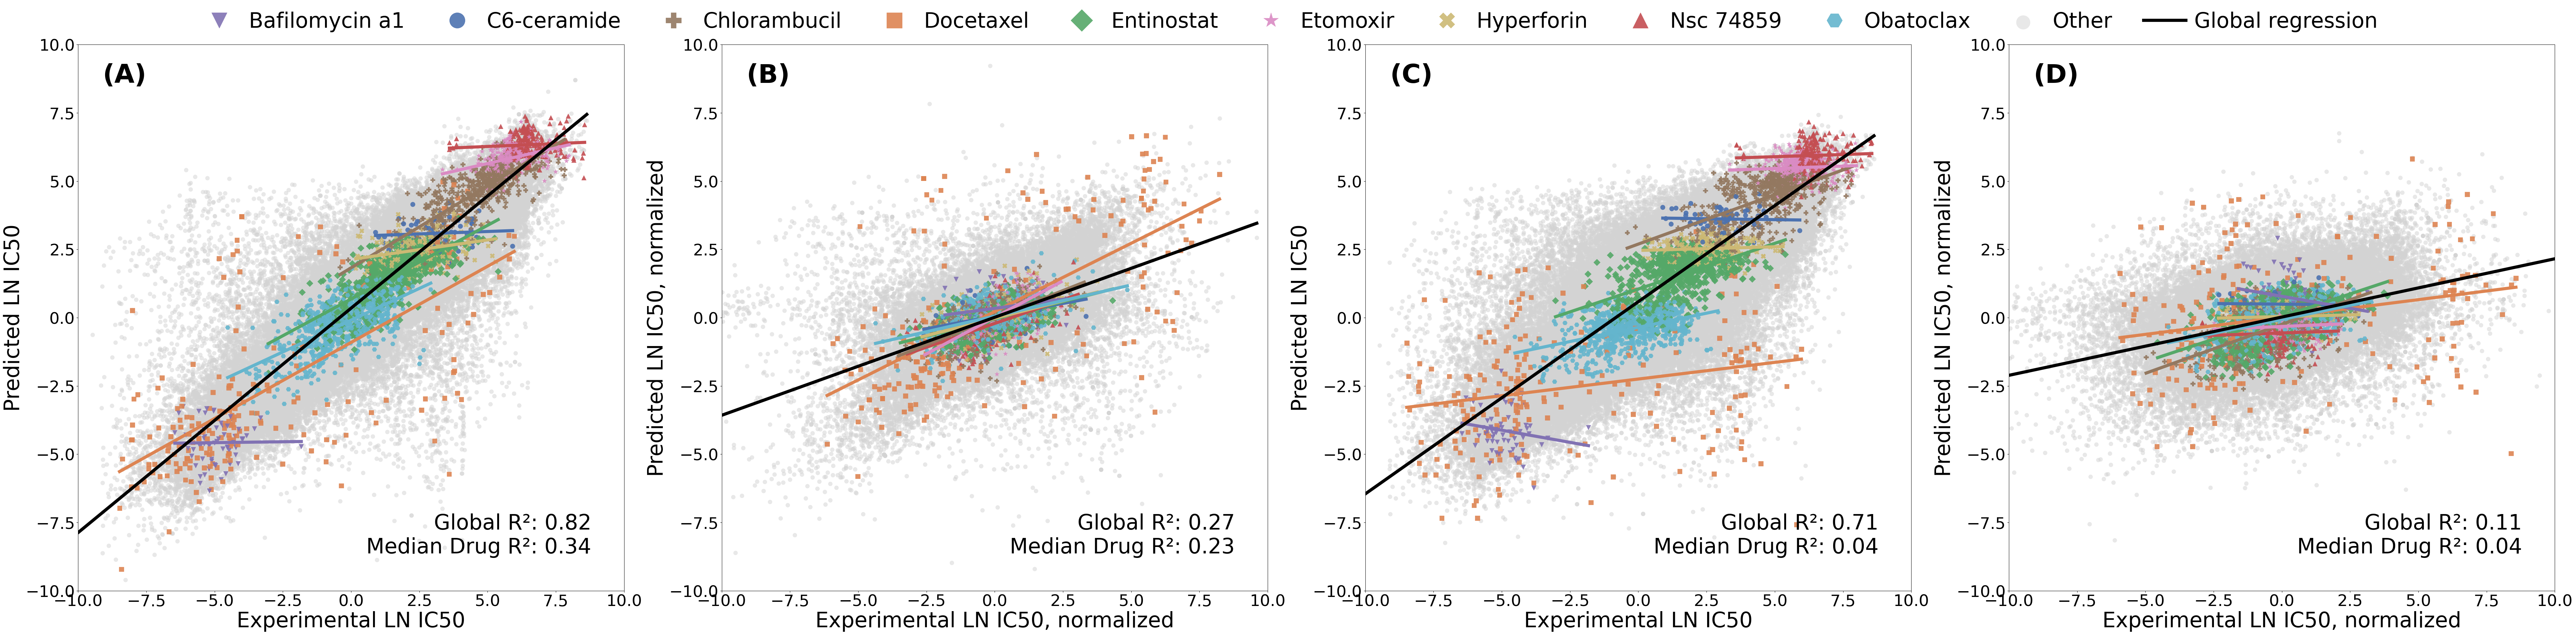

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(80, 24), constrained_layout=True)

plot_drug_scatter_with_regression(results_lpo, plot_id='LPO_'+ALGORITHM, caption_id="(A)", ax=axs[0], normalized=False)
plot_drug_scatter_with_regression(results_lpo_norm, plot_id='LPO_normalized_'+ALGORITHM, caption_id="(B)", ax=axs[1], normalized=True)
plot_drug_scatter_with_regression(results_lco, plot_id='LCO_'+ALGORITHM, caption_id="(C)", ax=axs[2], normalized=False)
plot_drug_scatter_with_regression(results_lco_norm, plot_id='LCO_normalized_'+ALGORITHM, caption_id="(D)", ax=axs[3], normalized=True)

fig.tight_layout()


def add_horizontal_legend(ax, fig, font_size=24, font_adder=0):
    handles, labels = ax.get_legend_handles_labels()

    # Capitalize and clean
    legend_items = [
        (h, l.capitalize()) for h, l in zip(handles, labels)
        if l not in ['Other', 'Global Regression']
    ]

    # Sort alphabetically
    legend_items = sorted(legend_items, key=lambda x: x[1].lower())

    # Append special items at the end
    special_items = [
        (h, l.capitalize()) for h, l in zip(handles, labels)
        if l in ['Other', 'Global Regression']
    ]
    legend_items += special_items

    # Unzip
    handles_final, labels_final = zip(*legend_items)

    # Add single row legend to full figure
    fig.legend(
        handles_final,
        labels_final,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.92),
        ncol=len(labels_final),
        fontsize=font_size + font_adder,
        frameon=False,
        markerscale=3.3,
        columnspacing=1.5,
        handletextpad=0.4
    )

add_horizontal_legend(axs[0], fig, font_size=33, font_adder=font_adder)


fig.savefig("figures/simpsons_paradox_scatter.pdf", bbox_inches='tight',dpi=300)

plt.show()
